In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [5]:
# Load the dataset
# url = "https://raw.githubusercontent.com/omairaasim/machine_learning/master/creditcard.csv"
df = pd.read_csv("/content/creditcard.csv")

# Display the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Basic statistics
print(df.describe())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [6]:
# Separate the features and the target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Check the distribution of the target after SMOTE
print(f"Original dataset shape: {y.value_counts()}")
print(f"Resampled dataset shape: {y_res.value_counts()}")


Original dataset shape: Class
0    284315
1       492
Name: count, dtype: int64
Resampled dataset shape: Class
0    284315
1    284315
Name: count, dtype: int64


In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)


In [9]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [10]:
# Predictions
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc}")


[[85276    19]
 [    0 85294]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

ROC-AUC Score: 0.9999996287362656


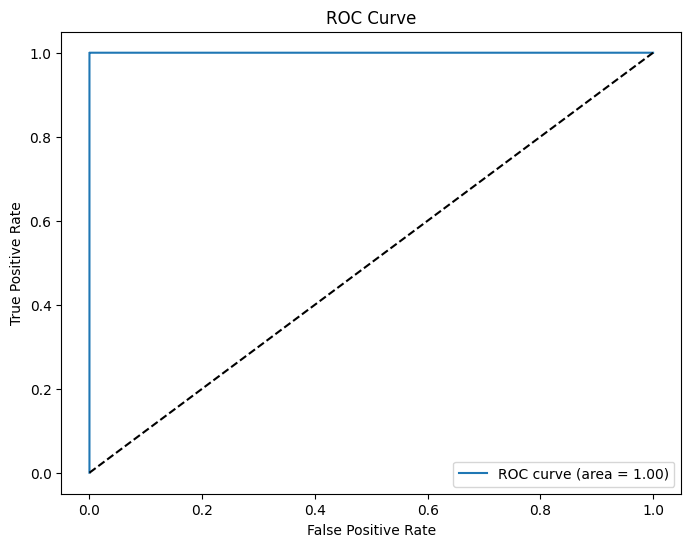

In [11]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best Parameters and Best Score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

# Retrain with the best estimator
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
# Evaluate on Test Data
y_pred_best = best_rf_model.predict(X_test)
y_pred_best_prob = best_rf_model.predict_proba(X_test)[:, 1]

# Final Evaluation
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
final_roc_auc = roc_auc_score(y_test, y_pred_best_prob)
print(f"Final ROC-AUC Score: {final_roc_auc}")
